Importation des library

In [11]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [12]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "15m"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [13]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-08 21:30:00+01:00,3128.78,3126.93,3130.43,3121.36,1663.4270
2025-12-08 21:45:00+01:00,3135.91,3128.79,3145.47,3125.35,7502.9793
2025-12-08 22:00:00+01:00,3128.18,3135.90,3141.49,3127.14,2691.4015
2025-12-08 22:15:00+01:00,3137.18,3128.18,3140.35,3126.69,1540.1861
2025-12-08 22:30:00+01:00,3136.58,3137.19,3153.00,3133.86,5377.4464


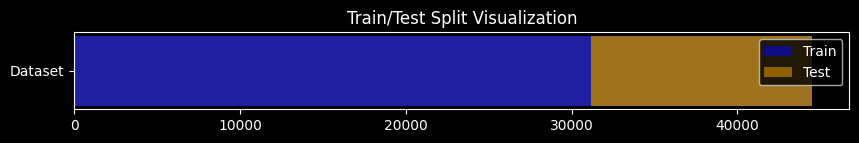

In [14]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [15]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

In [16]:
df.head()


,Close,Open,High,Low,Volume
Open time,,,,,
2024-09-01 01:00:00+02:00,2513.08,2517.01,2518.73,2512.41,411.6844
2024-09-01 01:15:00+02:00,2514.18,2513.07,2515.20,2511.42,453.7339
2024-09-01 01:30:00+02:00,2514.81,2514.18,2515.69,2512.23,398.6353
2024-09-01 01:45:00+02:00,2513.01,2514.81,2515.72,2511.25,433.9535
2024-09-01 02:00:00+02:00,2515.29,2513.00,2516.00,2510.84,593.7115


In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

for body_threshold in np.arange(0.0001, 0.01, 0.0001):
    df_test = df.copy()  # <-- copie fraîche à chaque tour

    df_test['body'] = (df_test['Close'] - df_test['Open']).abs() / df_test['Open']
    df_test['imbalance_up'] = (df_test['body'] > body_threshold) & (df_test['Close'] > df_test['Open'])
    df_test['imbalance_down'] = (df_test['body'] > body_threshold) & (df_test['Close'] < df_test['Open'])
    df_test['imbalance_high'] = np.where(df_test['imbalance_up'], df_test['High'], np.nan)
    df_test['imbalance_low'] = np.where(df_test['imbalance_down'], df_test['Low'], np.nan)
    df_test['last_imbalance_high'] = df_test['imbalance_high'].ffill()
    df_test['last_imbalance_low'] = df_test['imbalance_low'].ffill()
    df_test['long_signal'] = (df_test['last_imbalance_high'].notna()) & (df_test['Low'] <= df_test['last_imbalance_high']) & (df_test['imbalance_up'].shift(1).notna())
    df_test['short_signal'] = (df_test['last_imbalance_low'].notna()) & (df_test['High'] >= df_test['last_imbalance_low']) & (df_test['imbalance_down'].shift(1).notna())

    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['long_signal'],
        exits=df_test['short_signal'],
        init_cash=10000,
        fees=0.001,
        slippage=0.001,
        size_type='percent',
        size=0.05,
        freq='15m'
    )

    stats = portfolio.stats()
    stats['body_threshold'] = body_threshold
    stats = stats.to_frame().T
    stats.to_csv('backtest_4.csv', mode='a', header=not os.path.exists('backtest_4.csv'), index=False)
    
# Charger les résultats du backtest
df_results = pd.read_csv('backtest_4.csv')

# Nettoyer les données (remplacer les inf par NaN)
df_results.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1. GRAPHIQUE PRINCIPAL : Performances par seuil
fig1 = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Rendement total (%)', 'Ratio de Sharpe', 
                   'Maximum Drawdown (%)', 'Win Rate (%)',
                   'Profit Factor', 'Nombre de Trades'),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Graphique 1: Rendement total
fig1.add_trace(
    go.Scatter(
        x=df_results['body_threshold'],
        y=df_results['Total Return [%]'],
        mode='lines+markers',
        name='Rendement',
        line=dict(color='green', width=2),
        marker=dict(size=4),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Rendement:</b> %{y:.2f}%<br>'
    ),
    row=1, col=1
)

# Graphique 2: Ratio de Sharpe
fig1.add_trace(
    go.Scatter(
        x=df_results['body_threshold'],
        y=df_results['Sharpe Ratio'].fillna(0),
        mode='lines+markers',
        name='Sharpe',
        line=dict(color='blue', width=2),
        marker=dict(size=4),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Sharpe:</b> %{y:.3f}<br>'
    ),
    row=1, col=2
)

# Graphique 3: Max Drawdown
fig1.add_trace(
    go.Scatter(
        x=df_results['body_threshold'],
        y=df_results['Max Drawdown [%]'].fillna(0),
        mode='lines+markers',
        name='Max DD',
        line=dict(color='red', width=2),
        marker=dict(size=4),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Max DD:</b> %{y:.2f}%<br>'
    ),
    row=2, col=1
)

# Graphique 4: Win Rate
fig1.add_trace(
    go.Scatter(
        x=df_results['body_threshold'],
        y=df_results['Win Rate [%]'].fillna(0),
        mode='lines+markers',
        name='Win Rate',
        line=dict(color='purple', width=2),
        marker=dict(size=4),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Win Rate:</b> %{y:.2f}%<br>'
    ),
    row=2, col=2
)

# Graphique 5: Profit Factor
fig1.add_trace(
    go.Scatter(
        x=df_results['body_threshold'],
        y=df_results['Profit Factor'].replace([np.inf, -np.inf], np.nan).fillna(0),
        mode='lines+markers',
        name='Profit Factor',
        line=dict(color='orange', width=2),
        marker=dict(size=4),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Profit Factor:</b> %{y:.3f}<br>'
    ),
    row=3, col=1
)

# Graphique 6: Nombre de trades
fig1.add_trace(
    go.Scatter(
        x=df_results['body_threshold'],
        y=df_results['Total Trades'],
        mode='lines+markers',
        name='Trades',
        line=dict(color='brown', width=2),
        marker=dict(size=4),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Trades:</b> %{y}<br>'
    ),
    row=3, col=2
)

# Mise en page
fig1.update_layout(
    title='Analyse des Performances par Seuil de Body Threshold',
    height=1000,
    showlegend=False,
    hovermode='x unified'
)

# Ajouter des lignes de référence
fig1.add_hline(y=0, line_dash="dash", line_color="gray", row=1, col=1)
fig1.add_hline(y=0, line_dash="dash", line_color="gray", row=1, col=2)
fig1.add_hline(y=1, line_dash="dash", line_color="green", row=3, col=1)

fig1.show()

# 2. CARTE DE CHALEUR 2D: Rendement vs Win Rate
fig2 = go.Figure(data=go.Scatter(
    x=df_results['body_threshold'],
    y=df_results['Total Return [%]'],
    mode='markers',
    marker=dict(
        size=df_results['Win Rate [%]'].fillna(0)/2 + 5,
        color=df_results['Sharpe Ratio'].fillna(0),
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title="Sharpe Ratio"),
        sizemode='diameter',
        sizeref=2.0,
        opacity=0.8
    ),
    text=[f"Seuil: {t:.5f}<br>Return: {r:.2f}%<br>Win Rate: {w:.1f}%<br>Sharpe: {s:.3f}<br>Trades: {n}" 
          for t, r, w, s, n in zip(
              df_results['body_threshold'],
              df_results['Total Return [%]'],
              df_results['Win Rate [%]'].fillna(0),
              df_results['Sharpe Ratio'].fillna(0),
              df_results['Total Trades']
          )],
    hovertemplate='%{text}<extra></extra>'
))

fig2.update_layout(
    title='Carte de Performance: Taille = Win Rate, Couleur = Sharpe Ratio',
    xaxis_title='Body Threshold',
    yaxis_title='Rendement Total (%)',
    height=600
)
fig2.show()

# 3. GRAPHIQUE 3D INTERACTIF
fig3 = go.Figure(data=[go.Scatter3d(
    x=df_results['body_threshold'],
    y=df_results['Win Rate [%]'].fillna(0),
    z=df_results['Total Return [%]'],
    mode='markers',
    marker=dict(
        size=8,
        color=df_results['Sharpe Ratio'].fillna(0),
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title="Sharpe Ratio")
    ),
    text=[f"Seuil: {t:.5f}<br>Return: {r:.2f}%<br>Win Rate: {w:.1f}%<br>Sharpe: {s:.3f}<br>Trades: {n}<br>Max DD: {d:.2f}%" 
          for t, r, w, s, n, d in zip(
              df_results['body_threshold'],
              df_results['Total Return [%]'],
              df_results['Win Rate [%]'].fillna(0),
              df_results['Sharpe Ratio'].fillna(0),
              df_results['Total Trades'],
              df_results['Max Drawdown [%]'].fillna(0)
          )],
    hovertemplate='%{text}<extra></extra>'
)])

fig3.update_layout(
    title='Analyse 3D: Seuil vs Win Rate vs Rendement',
    scene=dict(
        xaxis_title='Body Threshold',
        yaxis_title='Win Rate (%)',
        zaxis_title='Rendement Total (%)'
    ),
    height=700
)
fig3.show()

# 4. TOP 10 DES MEILLEURS PARAMÈTRES
# Créer un score composite
df_results['score'] = (
    df_results['Total Return [%]'] * 0.4 +
    df_results['Sharpe Ratio'].fillna(0) * 0.3 +
    df_results['Win Rate [%]'].fillna(0) * 0.1 -
    df_results['Max Drawdown [%]'].fillna(100) * 0.2
)

top_10 = df_results.nlargest(10, 'score').sort_values('score', ascending=False)

fig4 = go.Figure(data=[
    go.Bar(
        x=[f"{t:.5f}" for t in top_10['body_threshold']],
        y=top_10['score'],
        text=[f"Return: {r:.2f}%<br>Sharpe: {s:.2f}<br>Win: {w:.1f}%<br>Trades: {n}" 
              for r, s, w, n in zip(
                  top_10['Total Return [%]'],
                  top_10['Sharpe Ratio'].fillna(0),
                  top_10['Win Rate [%]'].fillna(0),
                  top_10['Total Trades']
              )],
        hovertemplate='<b>Seuil: %{x}</b><br>Score: %{y:.3f}<br>%{text}<extra></extra>',
        marker_color='lightgreen'
    )
])

fig4.update_layout(
    title='Top 10 des Meilleurs Paramètres (Score Composite)',
    xaxis_title='Body Threshold',
    yaxis_title='Score Composite',
    height=500
)
fig4.show()

# 5. TABLEAU INTERACTIF DES MEILLEURS PARAMÈTRES
print("=== TOP 10 DES MEILLEURS PARAMÈTRES ===")
top_10_display = top_10[['body_threshold', 'Total Return [%]', 'Sharpe Ratio', 
                         'Max Drawdown [%]', 'Win Rate [%]', 'Profit Factor', 
                         'Total Trades', 'score']].round(4)

print(top_10_display.to_string(index=False))

# 6. ZOOM SUR LA PLAGE PROMETTEUSE (0.0005 à 0.002)
df_zoom = df_results[(df_results['body_threshold'] >= 0.0005) & (df_results['body_threshold'] <= 0.002)]

fig5 = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Zoom Rendement (0.0005-0.002)', 'Zoom Sharpe Ratio',
                   'Zoom Win Rate', 'Zoom Profit Factor'),
    vertical_spacing=0.15
)

# Graphique zoom 1
fig5.add_trace(
    go.Scatter(
        x=df_zoom['body_threshold'],
        y=df_zoom['Total Return [%]'],
        mode='lines+markers',
        name='Rendement',
        line=dict(color='green', width=3),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Rendement:</b> %{y:.2f}%<br>'
    ),
    row=1, col=1
)

# Graphique zoom 2
fig5.add_trace(
    go.Scatter(
        x=df_zoom['body_threshold'],
        y=df_zoom['Sharpe Ratio'].fillna(0),
        mode='lines+markers',
        name='Sharpe',
        line=dict(color='blue', width=3),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Sharpe:</b> %{y:.3f}<br>'
    ),
    row=1, col=2
)

# Graphique zoom 3
fig5.add_trace(
    go.Scatter(
        x=df_zoom['body_threshold'],
        y=df_zoom['Win Rate [%]'].fillna(0),
        mode='lines+markers',
        name='Win Rate',
        line=dict(color='purple', width=3),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Win Rate:</b> %{y:.2f}%<br>'
    ),
    row=2, col=1
)

# Graphique zoom 4
fig5.add_trace(
    go.Scatter(
        x=df_zoom['body_threshold'],
        y=df_zoom['Profit Factor'].replace([np.inf, -np.inf], np.nan).fillna(0),
        mode='lines+markers',
        name='Profit Factor',
        line=dict(color='orange', width=3),
        hovertemplate='<b>Seuil:</b> %{x:.5f}<br><b>Profit Factor:</b> %{y:.3f}<br>'
    ),
    row=2, col=2
)

fig5.update_layout(
    title='Zoom sur la Plage Prometteuse (0.0005 à 0.002)',
    height=700,
    showlegend=False,
    hovermode='x unified'
)
fig5.show()

# 7. EXPORT DES DONNÉES POUR ANALYSE APPROFONDIE
# Créer un DataFrame avec toutes les statistiques importantes
analysis_df = df_results[[
    'body_threshold', 'Total Return [%]', 'Sharpe Ratio', 'Max Drawdown [%]',
    'Win Rate [%]', 'Profit Factor', 'Total Trades', 'Expectancy',
    'Best Trade [%]', 'Worst Trade [%]', 'Avg Winning Trade [%]',
    'Avg Losing Trade [%]', 'Total Fees Paid'
]].round(4)

# Exporter en CSV pour analyse externe
analysis_df.to_csv('analyse_detaille.csv', index=False)
print("\nDonnées détaillées exportées dans 'analyse_detaille.csv'")

# 8. CALCUL DES CORRÉLATIONS
print("\n=== CORRÉLATIONS AVEC LE RENDEMENT ===")
correlation_cols = ['Total Return [%]', 'Sharpe Ratio', 'Max Drawdown [%]', 
                    'Win Rate [%]', 'Profit Factor', 'Total Trades']

corr_matrix = df_results[correlation_cols].corr()
print(corr_matrix['Total Return [%]'].sort_values(ascending=False))

# 9. RECOMMANDATIONS AUTOMATIQUES
print("\n=== RECOMMANDATIONS ===")

# Meilleur par rendement
best_return = df_results.loc[df_results['Total Return [%]'].idxmax()]
print(f"1. Meilleur rendement: seuil = {best_return['body_threshold']:.5f}")
print(f"   → Rendement: {best_return['Total Return [%]']:.2f}%, Trades: {best_return['Total Trades']}")

# Meilleur par Sharpe
best_sharpe = df_results.loc[df_results['Sharpe Ratio'].fillna(-999).idxmax()]
print(f"\n2. Meilleur Sharpe: seuil = {best_sharpe['body_threshold']:.5f}")
print(f"   → Sharpe: {best_sharpe['Sharpe Ratio']:.3f}, Rendement: {best_sharpe['Total Return [%]']:.2f}%")

# Meilleur par win rate (avec au moins 10 trades)
df_min_trades = df_results[df_results['Total Trades'] >= 10]
if len(df_min_trades) > 0:
    best_winrate = df_min_trades.loc[df_min_trades['Win Rate [%]'].fillna(0).idxmax()]
    print(f"\n3. Meilleur win rate: seuil = {best_winrate['body_threshold']:.5f}")
    print(f"   → Win Rate: {best_winrate['Win Rate [%]']:.2f}%, Trades: {best_winrate['Total Trades']}")

# Paramètre équilibré (score composite)
best_balanced = df_results.loc[df_results['score'].idxmax()]
print(f"\n4. Paramètre équilibré (score composite): seuil = {best_balanced['body_threshold']:.5f}")
print(f"   → Score: {best_balanced['score']:.3f}, Return: {best_balanced['Total Return [%]']:.2f}%")
print(f"   → Sharpe: {best_balanced['Sharpe Ratio']:.3f}, Max DD: {best_balanced['Max Drawdown [%]']:.2f}%")

# 10. GRAPHIQUE DE DENSITÉ DES RENDEMENTS
fig6 = px.histogram(
    df_results, 
    x='Total Return [%]',
    nbins=50,
    title='Distribution des Rendements par Seuil',
    labels={'Total Return [%]': 'Rendement (%)'},
    opacity=0.7
)

fig6.add_vline(x=0, line_dash="dash", line_color="red")
fig6.add_vline(x=df_results['Total Return [%]'].median(), line_dash="dot", line_color="green")

fig6.update_layout(
    height=500,
    showlegend=False
)
fig6.show()

print("\n=== ANALYSE TERMINÉE ===")
print("Conseils pour optimisation:")
print("1. Zoomer sur la plage 0.0005-0.0015 où les performances semblent meilleures")
print("2. Éviter les seuils > 0.002 qui génèrent trop de trades avec faible win rate")
print("3. Considérer le paramètre équilibré (score composite) pour un compromis risque/rendement")

=== TOP 10 DES MEILLEURS PARAMÈTRES ===
 body_threshold  Total Return [%]  Sharpe Ratio  Max Drawdown [%]  Win Rate [%]  Profit Factor  Total Trades   score
         0.0004            2.0854        1.1442            1.8032      100.0000            NaN             2 10.8168
         0.0003            1.9107        1.0563            1.8032      100.0000            NaN             1 10.7205
         0.0006            3.6661        1.7444            1.9365       83.3333        14.6665             6  9.9358
         0.0009            4.2854        2.2091            1.0896       57.1429         7.1544            14  7.8733
         0.0005            0.7865        0.5182            1.5246       75.0000         3.7294             4  7.6651
         0.0008            2.8475        1.6377            1.0896       60.0000         6.6686            10  7.4124
         0.0011            2.6201        1.5559            1.0751       53.3333         2.9387            30  6.6331
         0.0012         


Données détaillées exportées dans 'analyse_detaille.csv'

=== CORRÉLATIONS AVEC LE RENDEMENT ===
Total Return [%]    1.000000
Sharpe Ratio        0.997513
Profit Factor       0.691149
Win Rate [%]        0.371967
Total Trades       -0.728070
Max Drawdown [%]   -0.921737
Name: Total Return [%], dtype: float64

=== RECOMMANDATIONS ===
1. Meilleur rendement: seuil = 0.00090
   → Rendement: 4.29%, Trades: 14

2. Meilleur Sharpe: seuil = 0.00090
   → Sharpe: 2.209, Rendement: 4.29%

3. Meilleur win rate: seuil = 0.00970
   → Win Rate: 62.77%, Trades: 94

4. Paramètre équilibré (score composite): seuil = 0.00040
   → Score: 10.817, Return: 2.09%
   → Sharpe: 1.144, Max DD: 1.80%



=== ANALYSE TERMINÉE ===
Conseils pour optimisation:
1. Zoomer sur la plage 0.0005-0.0015 où les performances semblent meilleures
2. Éviter les seuils > 0.002 qui génèrent trop de trades avec faible win rate
3. Considérer le paramètre équilibré (score composite) pour un compromis risque/rendement
